![](http://pic1.tsingdataedu.com/%E9%87%8F%E5%8C%96banner.jpg)

# 推进分析下的均线策略
#### [稀牛学院 x 网易云课程]《AI量化交易》课程资料 by [老喵]

## Part1 手把手教你搭建CTA回测系统框架
#### \[稀牛学院 x 网易云课程\]《AI量化交易》课程资料 by [老喵]

In [1]:
import talib
import pandas as pd
import numpy as np
import tushare as ts
import datetime

class backtest_days:

    def __init__(self,TimestampSignal,TimestampPrice,opencost,closecost):
        self.TimestampSignal=TimestampSignal
        self.TimestampPrice=TimestampPrice
        self.opencost=opencost
        self.closecost=closecost

        
    
    # calculate the returns from long operations
    # given open price, close price, cost of open the position, cost for close the position
    def long(self,openprice,closeprice,opencost,closecost):
        return ((closeprice*(1-closecost))/(openprice*(1+opencost))-1)


    # calculate the returns from short operations
    # given open price, close price, cost of open the position, cost for close the position        
    def short(self,openprice,closeprice,opencost,closecost):
        nominator=openprice*(1-opencost)-closeprice*(1+closecost)
        denominator=openprice*(1-opencost)
        return (nominator/denominator)
    
    # find the first set of transaction: buy and then sell, or short and then cover 
    # i.e. find the first example of pair 1,-1 or -1,1
    # if either actionindex1=='end' or actionindex2=='end', then we shouldn't preceed forward
    # action is a munpy array or a pandas series    
    def trading_index_finder(self,actions):
        # get the index for the first nonzero
        if len(actions)==1:
            actionindex1='end'
        else:
            actionindex1=0
     
            
        try:
            if (actions.iloc[actionindex1]==1):
                actionindex2=np.where(actions==0)[0]
                actionindex2=actionindex2[actionindex2>actionindex1][0]
            
            if (actions.iloc[actionindex1]==0):
                actionindex2=np.where(actions==1)[0]
                actionindex2=actionindex2[actionindex2>actionindex1][0]
        except:
            actionindex2='end'       
            
        return [actionindex1,actionindex2]   
    
    
    # to make decision every 30 mins and the dicided if we need to hold the position for another day
    # r is how much percentage rate do we need to do stoploss 
    # Type is LongOnly ShortOnly LongShort 
    def crossday_backtest_everyday(self):
        datevalues=[[self.TimestampSignal['Date'].iloc[0],0]]
        TimestampSignal=self.TimestampSignal
        while (len(TimestampSignal)>0):
            
            # find the first set of transaction: buy and then sell, or short and then cover 
            [actionindex1,actionindex2]=self.trading_index_finder(TimestampSignal['Prediction'])
            
            # that is the end of a loop, break out of the loop
            if (actionindex1=='end'):
                break
            
            if (actionindex2=='end'):
                [Date1,Action1]=TimestampSignal[['Date','Prediction']].iloc[actionindex1]
                [Date2,Action2]=TimestampSignal[['Date','Prediction']].iloc[-1]
                
            if ((actionindex1!='end') & (actionindex2!='end')):
                [Date1,Action1]=TimestampSignal[['Date','Prediction']].iloc[actionindex1]
                [Date2,Action2]=TimestampSignal[['Date','Prediction']].iloc[actionindex2]
            
            # get the trading price 
            DTtradep=self.TimestampPrice[(self.TimestampPrice['Date']>=Date1) & (self.TimestampPrice['Date']<=Date2)]
        
            
            if (Action1==1):
                payoff=self.long(DTtradep['close'].iloc[0],DTtradep['close'].iloc[-1],self.opencost,self.closecost)
                datevalues.append([DTtradep['Date'].iloc[-1],payoff]) 

            if (Action1==(0)):
                payoff=self.short(DTtradep['close'].iloc[0],DTtradep['close'].iloc[-1],self.opencost,self.closecost)
                datevalues.append([DTtradep['Date'].iloc[-1],payoff])
                 
            
            # update the TimestampSignal
            TimestampSignal=TimestampSignal[TimestampSignal['Date']>=DTtradep['Date'].iloc[-1]]
            #print (DTtradep['Date'].iloc[-1])
            
        return datevalues

## Part2 基于推进分析的双均线策略回测与评价
#### \[稀牛学院 x 网易云课程\]《AI量化交易》课程资料 by [老喵]

In [2]:

def SearchForBestCoef(TimestampPrice,coef):
    valuemax=0
    for m in coef:
        for n in coef:
            if m<n:         
                ShortSMA=talib.SMA(TimestampPrice['close'].values,m)
                LongSMA=talib.SMA(TimestampPrice['close'].values,n)
                TradingSignal=(ShortSMA>LongSMA).astype(int)#默认NaN>NaN是0
                TimestampPrice['Prediction']=TradingSignal
                TimestampSignal=TimestampPrice[['Date','Prediction']]
                TimestampSignal=TimestampSignal.sort_values(by='Date')
                TimestampSignal=TimestampSignal.reset_index(drop=True)
                backtestresult=backtest_days(TimestampSignal,TimestampPrice,opencost=3/10000,closecost=3/10000)                
                datevalues=backtestresult.crossday_backtest_everyday()
                datevalues=pd.DataFrame(datevalues)
                datevalues.columns=['Date','Return']
                if datevalues['Return'].sum()>valuemax:
                    valuemax=datevalues['Return'].sum()
                    coefmax=[m,n]
    return coefmax

In [3]:
#TimestampPrice=ts.get_h_data('000300',index=True,start='2005-01-01')
#TimestampPrice.to_pickle(r'C:\Users\maozh\Desktop\其他\上网课\TimestampPrice.pkl')
TimestampPrice=pd.read_pickle('/home/ds/data/quantification/TimestampPrice.pkl')
TimestampPrice['Date']=TimestampPrice.index
TimestampPrice['Date']=[x.date() for x in TimestampPrice['Date']]
TimestampPrice=TimestampPrice[TimestampPrice['Date']>=datetime.date(2010,4,19)]
TimestampPrice=TimestampPrice.sort_values(by='Date')
TimestampPrice=TimestampPrice.reset_index(drop=True)
TimestampPrice=TimestampPrice[TimestampPrice['Date']<datetime.date(2012,6,30)]
TimestampPrice.head()

,open,high,close,low,volume,amount,Date
0,3313.499,3313.499,3176.423,3175.441,8841630400,118855974912,2010-04-19
1,3176.414,3196.646,3173.374,3130.960,6413786000,88005967872,2010-04-20
2,3178.877,3237.537,3236.679,3164.765,6692833200,93373374464,2010-04-21
3,3222.680,3231.985,3201.541,3177.726,7108168800,98970386432,2010-04-22
4,3198.784,3224.739,3190.003,3172.578,6125268000,92115673088,2010-04-23


In [4]:
opencost=3/10000
closecost=3/10000
coef=[2, 3, 5, 8, 13, 21, 34, 55, 89, 144]

OOSTimestampSignal=[]
for TradingDay in TimestampPrice['Date']:
    if TradingDay>datetime.date(2010,12,30):
        print (TradingDay)
        InSample=TimestampPrice[TimestampPrice['Date']<TradingDay]
        [m,n]=SearchForBestCoef(InSample,coef)

        OutofSample=TimestampPrice[TimestampPrice['Date']<=TradingDay]
        ShortSMA=talib.SMA(TimestampPrice['close'].values,m)
        LongSMA=talib.SMA(TimestampPrice['close'].values,n)
        if ShortSMA[-1]>LongSMA[-1]:
            OOSTimestampSignal.append([TradingDay, 1])
        else:
            OOSTimestampSignal.append([TradingDay, 0])

OOSTimestampSignal=pd.DataFrame(OOSTimestampSignal)
OOSTimestampSignal.columns=['Date','Prediction']



2010-12-31


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


2011-01-04
2011-01-05
2011-01-06
2011-01-07
2011-01-10
2011-01-11
2011-01-12
2011-01-13
2011-01-14
2011-01-17
2011-01-18
2011-01-19
2011-01-20
2011-01-21
2011-01-24
2011-01-25
2011-01-26
2011-01-27
2011-01-28
2011-01-31
2011-02-01
2011-02-09
2011-02-10
2011-02-11
2011-02-14
2011-02-15
2011-02-16
2011-02-17
2011-02-18
2011-02-21
2011-02-22
2011-02-23
2011-02-24
2011-02-25
2011-02-28
2011-03-01
2011-03-02
2011-03-03
2011-03-04
2011-03-07
2011-03-08
2011-03-09
2011-03-10
2011-03-11
2011-03-14
2011-03-15
2011-03-16
2011-03-17
2011-03-18
2011-03-21
2011-03-22
2011-03-23
2011-03-24
2011-03-25
2011-03-28
2011-03-29
2011-03-30
2011-03-31
2011-04-01
2011-04-06
2011-04-07
2011-04-08
2011-04-11
2011-04-12
2011-04-13
2011-04-14
2011-04-15
2011-04-18
2011-04-19
2011-04-20
2011-04-21
2011-04-22
2011-04-25
2011-04-26
2011-04-27
2011-04-28
2011-04-29
2011-05-03
2011-05-04
2011-05-05
2011-05-06
2011-05-09
2011-05-10
2011-05-11
2011-05-12
2011-05-13
2011-05-16
2011-05-17
2011-05-18
2011-05-19
2011-05-20

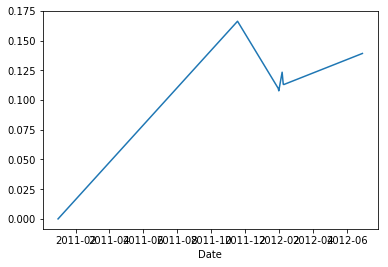

In [5]:
backtestresult=backtest_days(OOSTimestampSignal,TimestampPrice,opencost=3/10000,closecost=3/10000)                
datevalues=backtestresult.crossday_backtest_everyday()
datevalues=pd.DataFrame(datevalues)
datevalues.columns=['Date','Return']                
datevalues['Value']=datevalues['Return'].cumsum()
datevalues.set_index(['Date'],inplace=True)


import matplotlib.pyplot as plt
plt.figure()
datevalues['Value'].plot()
plt.show()

In [6]:
OOSTimestampSignal.head()

,Date,Prediction
0,2010-12-31,0
1,2011-01-04,0
2,2011-01-05,0
3,2011-01-06,0
4,2011-01-07,0


## 版权归 © 稀牛学院 所有 保留所有权利
![](http://pic1.tsingdataedu.com/%E7%A8%80%E7%89%9B%20x%20%E7%BD%91%E6%98%93.png)